# Basic Cross-Validation Experiment on the ExtraSensory data set with Backend Comparison

## Set up the Notebook

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys, os
sys.path.insert(0, os.path.abspath('..'))
os.chdir(os.path.abspath('..'))

#Disable multi-threading in NumPy 
os.environ["MKL_NUM_THREADS"] = "1" 
os.environ["NUMEXPR_NUM_THREADS"] = "1" 
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"

import mkl
mkl.get_max_threads()
mkl.set_num_threads(1)

## Import modules

In [2]:
from Blocks.data_loader import extrasensory_data_loader
from Blocks.dummy_dataloader import dummy_data_loader
from Blocks.filter import MisingLabelFilter,  MisingDataColumnFilter, Take
from Blocks.imputer import Imputer
from Blocks.normalizer import Normalizer
from Blocks.experimental_protocol import ExpTrainTest, ExpCV, ExpWithin
from Blocks.results_analysis import ResultsConcat, ResultsCVSummarize, DataYieldReport

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn import tree
from sklearn.dummy import DummyClassifier

import matplotlib.pyplot as plt

from Workflow.workflow import workflow
import Workflow.compute_graph
import time
import pandas as pd


## Define the workflow

This workflow performs four train/test experiments on the ExtraSensory data set sleeping prediction task to illustrate the use of different scheduler back ends. The data are loaded once, followed by four parallel copies of the remaining workflow, which includes a column filter that screens out feature dimensions that are less than 20% observed, a missing label filter that removes instances without labels, mean imputation and feature normalization. 

The demonstration compares the run time of three different workflow scheduler backends:  sequential, multithreaded, and multiprocess. We run the parallel schedulers with 1, 2 and 4 workers. We note that due to communication overhead between the master and worker threads in the multi-process backend, and issues with Python's global interpreter lock in the multi-threaded backend, parallel speedups can be less than linear even for seemingly embarassingly parallel tasks. Parallel speedups also depend on the number of avilable cores. Also note that this demo requires an extended run time. 

In [59]:
df_raw    = dummy_data_loader();
flow=workflow(df_raw)
output=flow.run(backend="sequential", num_workers=1, monitor=False, from_scratch=True)
# print(df_raw.out.keys())

Running Scheduler sequential
  Running Sequential Scheduler

Running step  Dummy Data Loader
200
Time taken by node  Dummy Data Loader : 1.38846755027771

  Workflow complete



In [60]:
print(df_raw.out['dataframe'].head)

<bound method NDFrame.head of                    0             1             2             3             4  \
ID                                                                             
0       12999.352391  18335.147447  15543.051874  15739.743958   5668.286360   
1        4671.613398  14705.112003   6002.050708   3050.797414   9686.337953   
2        7507.741041   5347.883160  15990.008719  10977.812083    154.178176   
3       13603.382065  13441.208441   5275.613989  11914.658814    277.169785   
4        8408.512811  19787.938397  11987.949435  17693.289923  10310.333029   
5        7619.191378   3921.936892   2670.100239   2828.336617  19557.525015   
6         745.950866   8092.875236  10487.603515   8297.993283  15490.181730   
7        7864.522071  18499.655554  16949.379617  11052.657816  16061.916586   
8       15202.529269  17243.843680   1154.523911  11531.155716  18690.856872   
9         221.190615   6763.077862  15355.609295   1190.492084  18687.915658   
10      15

sequential 1
Running Scheduler sequential
  Running Sequential Scheduler

Running step ES Data Loader
  Loading Extrasensory pkl file...

Running step Missing Data Column Filter

Running step Missing Label Filter

Running step Imputer
  Imputer: Running on matrix of size 285268x224

Running step Normalizer
  Normalizer: running matrix of size 285268x224

Running step EXP-TT: LR
  Fitting and testing LR

Running step Missing Data Column Filter

Running step Missing Label Filter

Running step Imputer
  Imputer: Running on matrix of size 285268x224

Running step Normalizer
  Normalizer: running matrix of size 285268x224

Running step EXP-TT: LR
  Fitting and testing LR

  Workflow complete

sequential 1 174.877507686615
multithread 1
Running Scheduler multithread
  Running Parallel Scheduler

Scheduled: ES Data Loader
Running: ES Data Loader
  Loading Extrasensory pkl file...
Done: ES Data Loader
Scheduled: Missing Data Column Filter
Scheduled: Missing Data Column Filter
Running: Missing 

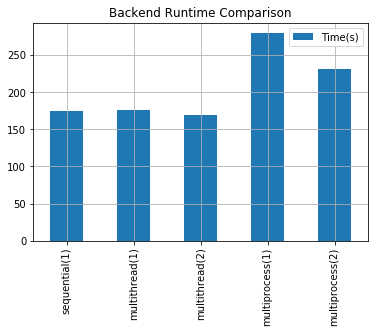

In [4]:
estimators = {"LR": LogisticRegression(solver="lbfgs",max_iter=1000)}
metrics    = [accuracy_score, f1_score, precision_score, recall_score]

res       = []
df_raw    = extrasensory_data_loader(label="SLEEPING");
for i in range(4):
    df_cf     = MisingDataColumnFilter(df_raw);
    df_lf     = MisingLabelFilter(df_cf);
    df_imp    = Imputer(df_lf)
    df_norm   = Normalizer(df_imp);
    res       += ExpTrainTest(df_norm, estimators, metrics=metrics);

configs = {"sequential":[1],
           "multithread":[1],
           "multiprocess":[1,2,4]
          }

results={}
for config in configs:
    for workers in configs[config]:
        
        print(config, workers)
        flow=workflow(res);        
        start = time.time()
        output=flow.run(backend=config, num_workers=workers, monitor=False, from_scratch=True);
        results[config+"(%d)"%(workers)] = time.time()-start
        print(config, workers, results[config+"(%d)"%(workers)])
    
time_df = pd.DataFrame(list(results.values()),columns=["Time(s)"], index=list(results.keys()))
display(time_df.plot(kind='bar', grid=True, title="Backend Runtime Comparison"))

pipeline 1
Running Scheduler pipeline
  Running Sequential Scheduler

1
Running step ES Data Loader
2062310801984
  Loading Extrasensory pkl file...
Time taken by node ES Data Loader : 7.844552516937256
Time taken by ES Data Loader : 7.844552516937256

Running step Missing Data Column Filter.Missing Label Filter.Imputer.Normalizer.EXP-TT: LR
2062310803664
Time taken by node Missing Data Column Filter : 0.7089366912841797
2062310803776
Time taken by node Missing Label Filter : 0.2622947692871094
2062310803832
  Imputer: Running on matrix of size 285268x224
Time taken by node Imputer : 2.960745096206665
2062310803944
  Normalizer: running matrix of size 285268x224
Time taken by node Normalizer : 3.4912402629852295
2062310804056
  Fitting and testing LR
Time taken by node EXP-TT: LR : 90.49938678741455
Time taken by EXP-TT: LR : 97.93360924720764

Running step Missing Data Column Filter.Missing Label Filter.Imputer.Normalizer.EXP-TT: LR
2062310803160
Time taken by node Missing Data Column

Time taken by node Missing Data Column Filter : 2.1861462593078613Time taken by node Missing Data Column Filter : 2.029557466506958
2062310803776

2062310802768
Time taken by node Missing Label Filter : 0.6814754009246826
2062310802824
Time taken by node Missing Label Filter : 0.7760601043701172
2062310803832
  Imputer: Running on matrix of size 285268x224
  Imputer: Running on matrix of size 285268x224
Time taken by node Imputer : 11.383154153823853Time taken by node Imputer : 11.421938419342041

2062310803944
2062310802936
  Normalizer: running matrix of size 285268x224  Normalizer: running matrix of size 285268x224

Time taken by node Normalizer : 6.2805304527282715
2062310804056
Time taken by node Normalizer : 6.642582178115845
2062310803048
  Fitting and testing LR
  Fitting and testing LR
Time taken by node EXP-TT: LR : 137.5235357284546
Time taken by EXP-TT: LR : 158.07650589942932
None
Done: Missing Data Column Filter.Missing Label Filter.Imputer.Normalizer.EXP-TT: LR
Time take

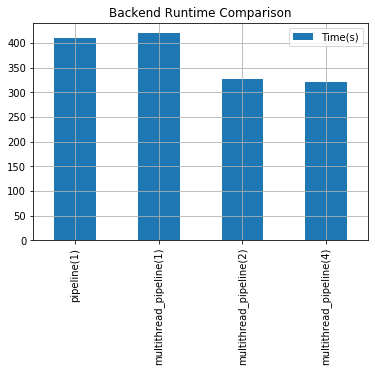

In [17]:
estimators = {"LR": LogisticRegression(solver="lbfgs",max_iter=1000)}
metrics    = [accuracy_score, f1_score, precision_score, recall_score]

res       = []
df_raw    = extrasensory_data_loader(label="SLEEPING");
for i in range(4):
    df_cf     = MisingDataColumnFilter(df_raw);
    df_lf     = MisingLabelFilter(df_cf);
    df_imp    = Imputer(df_lf)
    df_norm   = Normalizer(df_imp);
    res       += ExpTrainTest(df_norm, estimators, metrics=metrics);

configs = {
            "pipeline":[1],
            "multithread_pipeline":[1,2,4]
#             "multiprocess_pipeline":[2]
          }

results={}
for config in configs:
    for workers in configs[config]:
        
        print(config, workers)
        flow=workflow(res);        
        start = time.time()
        output=flow.run(backend=config, num_workers=workers, monitor=False, from_scratch=True);
        results[config+"(%d)"%(workers)] = time.time()-start
        print(config, workers, results[config+"(%d)"%(workers)])
    
time_df = pd.DataFrame(list(results.values()),columns=["Time(s)"], index=list(results.keys()))
display(time_df.plot(kind='bar', grid=True, title="Backend Runtime Comparison"))

In [15]:
estimators = {"LR": LogisticRegression(solver="lbfgs",max_iter=1000)}
metrics    = [accuracy_score, f1_score, precision_score, recall_score]

res       = []
df_raw    = extrasensory_data_loader(label="SLEEPING");
for i in range(4):
    df_cf     = MisingDataColumnFilter(df_raw);
    df_lf     = MisingLabelFilter(df_cf);
    df_imp    = Imputer(df_lf)
    df_norm   = Normalizer(df_imp);
    res       += ExpTrainTest(df_norm, estimators, metrics=metrics);

configs = {
#             "pipeline":[1]
#             "multithread_pipeline":[2]
            "multiprocess_pipeline":[1]
          }

results={}
for config in configs:
    for workers in configs[config]:
        
        print(config, workers)
        flow=workflow(res);        
#         start = time.time()
#         output=flow.run(backend=config, num_workers=workers, monitor=False, from_scratch=True);
#         results[config+"(%d)"%(workers)] = time.time()-start
#         print(config, workers, results[config+"(%d)"%(workers)])
    
# time_df = pd.DataFrame(list(results.values()),columns=["Time(s)"], index=list(results.keys()))
# display(time_df.plot(kind='bar', grid=True, title="Backend Runtime Comparison"))

multiprocess_pipeline 1
execute order : 
ES Data Loader2357085491384
Missing Data Column Filter2357085493232
Missing Label Filter2357085493344
Imputer2357085493400
Normalizer2357085493512
EXP-TT: LR2357085493624
Missing Data Column Filter2357085492728
Missing Label Filter2357085492840
Imputer2357085492896
Normalizer2357085493008
EXP-TT: LR2357085493120
Missing Data Column Filter2357085492224
Missing Label Filter2357085492336
Imputer2357085492392
Normalizer2357085492504
EXP-TT: LR2357085492616
Missing Data Column Filter2357085491272
Missing Label Filter2357085491832
Imputer2357085491888
Normalizer2357085492000
EXP-TT: LR2357085492112
         pre_order : 
ES Data Loader2357085491384
Missing Data Column Filter2357085491272
Missing Label Filter2357085491832
Imputer2357085491888
Normalizer2357085492000
EXP-TT: LR2357085492112
Missing Data Column Filter2357085492224
Missing Label Filter2357085492336
Imputer2357085492392
Normalizer2357085492504
EXP-TT: LR2357085492616
Missing Data Column Fil

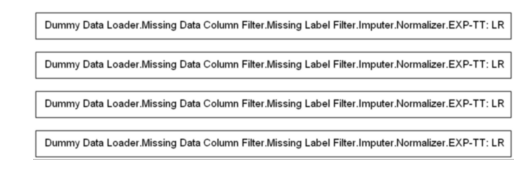

Running Scheduler multithread_pipeline
  Running Parallel Scheduler

2691034343800
200
Scheduled:  Dummy Data Loader.Missing Data Column Filter.Missing Label Filter.Imputer.Normalizer.EXP-TT: LR
2691034342680
200
Scheduled:  Dummy Data Loader.Missing Data Column Filter.Missing Label Filter.Imputer.Normalizer.EXP-TT: LR
Running:  Dummy Data Loader.Missing Data Column Filter.Missing Label Filter.Imputer.Normalizer.EXP-TT: LR
2691034343240
200
Scheduled:  Dummy Data Loader.Missing Data Column Filter.Missing Label Filter.Imputer.Normalizer.EXP-TT: LR
Running:  Dummy Data Loader.Missing Data Column Filter.Missing Label Filter.Imputer.Normalizer.EXP-TT: LR
2691034342176Scheduled:  Dummy Data Loader.Missing Data Column Filter.Missing Label Filter.Imputer.Normalizer.EXP-TT: LR
Running:  Dummy Data Loader.Missing Data Column Filter.Missing Label Filter.Imputer.Normalizer.EXP-TT: LR

200
Running:  Dummy Data Loader.Missing Data Column Filter.Missing Label Filter.Imputer.Normalizer.EXP-TT: LR
Tim

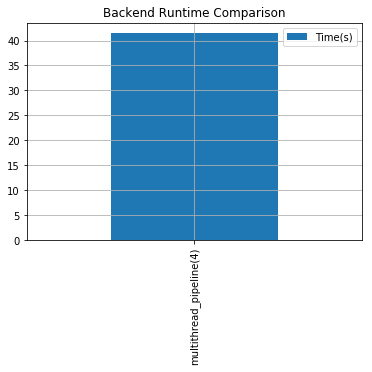

In [3]:
estimators = {"LR": LogisticRegression(solver="lbfgs",max_iter=1000)}
metrics    = [accuracy_score, f1_score, precision_score, recall_score]

res       = []
# df_raw    = extrasensory_data_loader(label="SLEEPING");
# df_raw    = dummy_data_loader();
for i in range(4):
    df_raw    = dummy_data_loader();
    df_cf     = MisingDataColumnFilter(df_raw);
    df_lf     = MisingLabelFilter(df_cf);
    df_imp    = Imputer(df_lf)
    df_norm   = Normalizer(df_imp);
    res       += ExpTrainTest(df_norm, estimators, metrics=metrics);

configs = {
#             "pipeline":[1]
            "multithread_pipeline":[4],
#             "multiprocess":[1,2,4]
          }

results={}
for config in configs:
    for workers in configs[config]:
        
        print(config, workers)
        flow=workflow(res);
        flow.drawPipelined(); plt.show();
        start = time.time()
        output=flow.run(backend=config, num_workers=workers, monitor=False, from_scratch=True);
        results[config+"(%d)"%(workers)] = time.time()-start
        print(config, workers, results[config+"(%d)"%(workers)])
    
time_df = pd.DataFrame(list(results.values()),columns=["Time(s)"], index=list(results.keys()))
display(time_df.plot(kind='bar', grid=True, title="Backend Runtime Comparison"))

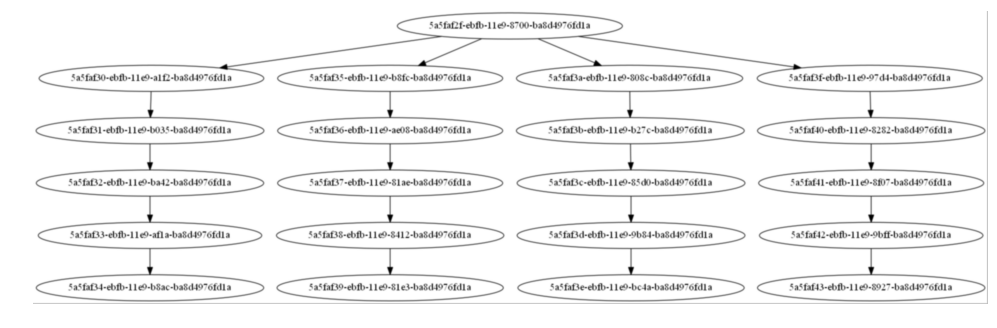

In [7]:
import networkx as nx
from networkx.drawing.nx_agraph import write_dot, graphviz_layout
import matplotlib.pyplot as plt
from IPython import display
import matplotlib.image as mpimg
b = nx.dag_to_branching(flow.graph)
pdot = nx.drawing.nx_pydot.to_pydot(b)
pdot.write_png("Temp/temp.png")
pdot.write_pdf("Temp/temp.pdf")
img=mpimg.imread('Temp/temp.png')
plt.figure(1,figsize=(img.shape[1]/100,img.shape[0]/100))
plt.imshow(img,interpolation='bicubic')
plt.axis('off')
plt.show()

In [75]:
flow.draw(); plt.show();

FileNotFoundError: [Errno 2] No such file or directory: 'Temp/temp.png'

In [10]:
execute_order = list(nx.topological_sort(flow.graph))
node_list = list(nx.dfs_preorder_nodes(flow.graph, source=execute_order[0]))
process_dict = {}
marked_nodes = []
key_num = 0
for i, id in enumerate(node_list):
    marked_nodes.append(id)
    if len(list(flow.graph.predecessors(id))) == 0:
#         marked_nodes.append(id)
        process_dict[key_num] = [flow.graph.node[id]["block"].name]
        if len(list(flow.graph.successors(id))) == 1:
            if list(flow.graph.successors(id))[0] in marked_nodes:
                key_num += 1
        elif len(list(flow.graph.successors(id))) == 0:
            key_num += 1
        elif len(list(flow.graph.successors(id))) > 1:
#             marked_nodes.append(id)
            key_num += 1
            
    elif len(list(flow.graph.predecessors(id))) == 1:
        if len(list(flow.graph.successors(id))) == 1:
#                 marked_nodes.append(id)
            if key_num not in process_dict.keys():
                process_dict[key_num] = [flow.graph.node[id]["block"].name]
            else:
                process_dict[key_num].append(flow.graph.node[id]["block"].name)
            if list(flow.graph.successors(id))[0] in marked_nodes:
#                 marked_nodes.append(id)
                key_num += 1
        elif len(list(flow.graph.successors(id))) == 0:
            if key_num not in process_dict.keys():
                process_dict[key_num] = [flow.graph.node[id]["block"].name]
                key_num += 1
            else:
                process_dict[key_num].append(flow.graph.node[id]["block"].name)
                key_num += 1
        elif len(list(flow.graph.successors(id))) > 1:
            if key_num not in process_dict.keys():
#                 marked_nodes.append(id)
                process_dict[key_num] = [flow.graph.node[id]["block"].name]
            else:
                process_dict[key_num].append(flow.graph.node[id]["block"].name)
#             marked_nodes.append(id)
            key_num += 1
                
    elif len(list(flow.graph.predecessors(id))) > 1:
        key_num += 1
#         marked_nodes.append(id)
        if len(list(flow.graph.successors(id))) == 1:
            process_dict[key_num] = [flow.graph.node[id]["block"].name]
            if list(flow.graph.successors(id))[0] in marked_nodes:
#                 marked_nodes.append(id)
                key_num += 1
        elif len(list(flow.graph.successors(id))) == 0:
            process_dict[key_num] = [flow.graph.node[id]["block"].name]
#             marked_nodes.append(id)
            key_num += 1
        elif len(list(flow.graph.successors(id))) > 1:
            process_dict[key_num] = [flow.graph.node[id]["block"].name]
#             marked_nodes.append(id)
            key_num += 1
    
print(process_dict)

{0: ['ES Data Loader'], 1: ['Missing Data Column Filter', 'Missing Label Filter', 'Imputer', 'Normalizer', 'EXP-TT: LR'], 2: ['Missing Data Column Filter', 'Missing Label Filter', 'Imputer', 'Normalizer', 'EXP-TT: LR'], 3: ['Missing Data Column Filter', 'Missing Label Filter', 'Imputer', 'Normalizer', 'EXP-TT: LR'], 4: ['Missing Data Column Filter', 'Missing Label Filter', 'Imputer', 'Normalizer', 'EXP-TT: LR']}


In [70]:
flow.drawPipelined(); plt.show();

FileNotFoundError: [Errno 2] No such file or directory: 'Temp/temp.png'